In [1]:
from math import log
import pandas as pd
import numpy as np
class decisionNode(object):
    '''建立决策树结点类'''
    def __init__(self,col=-1,value=None,results=None,tb=None,fb=None,samples=None):
        '''col:待检验的列索引值;value:为了使结果为true,当前列必须匹配的值
        tb,fb:下一层结点,result:dict,叶结点处,该分支的结果,其它结点处为None'''
        self.col=col
        self.value=value
        self.results=results
        self.tb=tb
        self.fb=fb
        self.samples=samples

class DecitionTree():
    def __init__(self, max_depth = 10, model = 'ID3'):
        self.max_depth = max_depth
        self.model = model
        self.tree = decisionNode()
    #计算信息熵
    def calcShannonEnt(self,x,y):
        numsamples = len(x)
        labelCounts = {}
        for n in range(numsamples):
            currentLabel = y[n][0]
            if currentLabel not in labelCounts:
                labelCounts[currentLabel] = 0
            labelCounts[currentLabel] += 1
        shannonEnt = 0.0
        for key in labelCounts:
            prob = float(labelCounts[key])/numsamples
            shannonEnt -= prob * log(prob, 2)
        return shannonEnt
    #计算基尼系数    
    def calcGiniEnt(self,x,y):
        numsamples = len(x)
        labelCounts = {}
        for n in range(numsamples):
            currentLabel = y[n][0]
            if currentLabel not in labelCounts:
                labelCounts[currentLabel] = 0
            labelCounts[currentLabel] += 1
        GiniEnt = 0.0
        for key in labelCounts:
            prob = float(labelCounts[key])/numsamples
            GiniEnt -= prob **2
        return GiniEnt
    #连续值 C3
    def choosebest(self,x,y):
        m = len(x)

        if self.model == 'ID3' or self.model == 'C4.5':
            calc = self.calcShannonEnt
        elif self.model == 'CART':
            calc = self.calcGiniEnt
        
        bestfeature = -1
        bestpoint = -1.0
        numFeatures = len(x[0])
        baseEntropy = calc(x,y)
        bestInfoGain = 0.0 
        for i in range(numFeatures):
            curfeature = []
            for j in range(m):
                curfeature.append(x[j][i])
            #print(curfeature)
            curfeature.sort()
            gain = 0.0
            point_id = (curfeature[-1]-curfeature[0])/10
            #两点中间取分割点
            for j in range(11):
                point = curfeature[0]+point_id*j
                Set = [[k for k in range(m) if x[k][i] < point],[k for k in range(m) if x[k][i] >= point]]
                p1 = float(len(Set[0])) / m
                p2 = float(len(Set[1])) / m
                split = 1
                if self.model == 'C4.5':
                    split = 0
                    if p1 != 0:
                        split -= p1 * log(p1,2)
                    if p2 != 0:
                        split -= p2 * log(p2,2)
                    if split == 0:
                        continue
                gain = (baseEntropy - p1 * calc([[x[n][i]] for n in Set[0]],[y[n] for n in Set[0]]) - p2 * calc([[x[n][i]] for n in Set[1]],[y[n] for n in Set[1]]))/split
                if gain > bestInfoGain:
                    bestInfoGain = gain
                    bestfeature = i
                    bestpoint = point
        return bestfeature,bestpoint,bestInfoGain
    #构建决策树
    def buildDTree(self,x,y,depth):
        max_depth = self.max_depth
        if depth>=max_depth:
            return decisionNode(results=self.uniquecounts(x,y)) #当树深度>=max_depth时，停止分叉，并返回该结点的类别
        
        #定义一些变量以记录最佳拆分条件
        best_gain=0
        bestFeat=None      #最佳拆分点:特征
        bestpoint=None          #最佳拆分点:特征取值
        
        labels = range(len(x[0]))
        bestFeat, bestpoint, best_gain = self.choosebest(x,y)
        #切分左子树和右子树
        best_set_tx = [x[n] for n in range(len(x)) if x[n][bestFeat] >=bestpoint]
        best_set_ty = [y[n] for n in range(len(x)) if x[n][bestFeat] >=bestpoint]
        
        best_set_fx = [x[n] for n in range(len(x)) if x[n][bestFeat] <bestpoint]
        best_set_fy = [y[n] for n in range(len(x)) if x[n][bestFeat] <bestpoint]
        #创建分支：
        if best_gain>0:
            TrueBranch=self.buildDTree(best_set_tx,best_set_ty,depth+1)
            FalseBranch=self.buildDTree(best_set_fx,best_set_fy,depth+1)
            return decisionNode(col=bestFeat,value=bestpoint,tb=TrueBranch,fb=FalseBranch)
        else:
            return decisionNode(results=self.uniquecounts(x,y))
        
    def uniquecounts(self,x,y):
        '''rows：输入样本集合;
        返回值dict
        '''
        results={}
        #print(rows)
        for i in range(len(x)):
            rs=y[i][0]
            #print(rs)
            if not rs in results.keys():
                results[rs]=0
            results[rs]+=1
        return results
    
    def fit(self,x,y):
        if type(x)==type(pd.DataFrame()) or type(x)==type(pd.Series()):
            x = x.values.tolist()
        if type(y)==type(pd.DataFrame()) or type(y)==type(pd.Series()) :
            y = [[n] for n in y.values]

        self.tree = self.buildDTree(x,y,1)
        
    def predict_sample(self,x):
        tree_1 = self.tree
        while tree_1.fb != None:
            if x[tree_1.col] < tree_1.value:
                tree_1 = tree_1.fb
            else:
                tree_1 = tree_1.tb
        #统计叶子结点的多数类别
        predict = sorted(tree_1.results.items(),key=lambda x:x[1])[-1][0]
        return predict
    
    def predict(self,x):
        if type(x)==type(pd.DataFrame()) or type(x)==type(pd.Series()):
            x = x.values.tolist()
        
        y_pre = [[self.predict_sample(n)] for n in x]
        return y_pre    
    

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv(r'D:\python data\kaggle-titanic-master\input\clean.csv')

In [15]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1],data.iloc[:, -1],test_size = 0.2)

In [16]:
dt = DecitionTree(model='CART')
dt.fit(x_train,y_train)
y_pred = dt.predict(x_train)
accuracy = len([n for n in range(len(y_pred)) if y_pred[n][0]==y_train.iloc[n]])/len(y_pred)
print('train accuracy:', accuracy)

train accuracy: 0.9240506329113924


In [17]:
y_pred = dt.predict(x_test)
accuracy = len([n for n in range(len(y_pred)) if y_pred[n][0]==y_test.iloc[n]])/len(y_pred)
print('test accuracy:',accuracy)

test accuracy: 0.7191011235955056


#随机森林

In [6]:
import random
class RandomForest:
    def __init__(self,ntrees = 100,max_depth=10, model='CART'):
        '''
        ntrees为构建决策树棵树
        max_depth为一棵树最大深度
        model所用模型
        '''
        self.trees = []
        self.ntrees = ntrees
        self.max_depth = max_depth
        self.model = model
        self.weight = {}
        
    def fit(self,x,y):
        #对x,y是pandas格式的进行转换
        if type(x)==type(pd.DataFrame()) or type(x)==type(pd.Series()):
            x = x.values.tolist()
        if type(y)==type(pd.DataFrame()) or type(y)==type(pd.Series()) :
            y = [[n] for n in y.values]

        for n in range(self.ntrees):
            dt = DecitionTree(self.max_depth,self.model)
            sx, sy = self.random_xy(x,y)
            dt.fit(sx, sy)
            self.trees.append(dt)
            del dt
        for n in y:
            if n[0] not in self.weight.keys():
                self.weight[n[0]]=0
            self.weight[n[0]]+=1
        
    def random_xy(self,x,y):
        '''
        切分x,y。形成随机特征的随机数量样本
        '''
        i_list = sorted(random.sample(range(len(x)),random.choice(range(int(len(x)/1.2),len(x)))))
        j_list = sorted(random.sample(range(len(x[0])),random.choice(range(int(len(x[0])/1.1),len(x[0])))))
        return [[x[i][j] for j in j_list] for i in i_list],[y[i] for i in i_list]
        
    def predict_sample(self,x):
        '''
        x为一个样本
        '''
        pred_dict = {}
        for tree in self.trees:
            pred = tree.predict([x])[0][0]
            if pred not in pred_dict.keys():
                pred_dict[pred] = 0
            pred_dict[pred] +=1
        
        for label in pred_dict.keys():
            pred_dict[label] = pred_dict[label]/self.weight[label]
        
        predict = sorted(pred_dict.items(),key=lambda x:x[1])[-1][0]
        return predict
        
    def predict(self,x):
        if type(x)==type(pd.DataFrame()) or type(x)==type(pd.Series()):
            x = x.values.tolist()
        y_pre = [[self.predict_sample(n)] for n in x]
        return y_pre  
    
    def predict_sample_proba(self,x):
        '''
        x为一个样本
        计算概率
        '''
        pred_dict = {}
        for tree in self.trees:
            pred = tree.predict([x])[0][0]
            if pred not in pred_dict.keys():
                pred_dict[pred] = 0
            pred_dict[pred] +=1
        
        for label in pred_dict.keys():
            pred_dict[label] = pred_dict[label]/self.weight[label]
        try:
            predict_proba = pred_dict[1]/sum(pred_dict.values())
        except:
            predict_proba = 0
        return [1-predict_proba,predict_proba]
    
    def predict_proba(self,x):
        if type(x)==type(pd.DataFrame()) or type(x)==type(pd.Series()):
            x = x.values.tolist()
        y_pre = [self.predict_sample_proba(n) for n in x]
        return y_pre

In [18]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1],data.iloc[:, -1],test_size = 0.2)
rf = RandomForest(model='CART')
rf.fit(x_train,y_train)
y_pred = rf.predict(x_train)
accuracy = len([n for n in range(len(y_pred)) if y_pred[n][0]==y_train.iloc[n]])/len(y_pred)
print('train accuracy:', accuracy)

train accuracy: 0.8255977496483825


In [19]:
y_pred = rf.predict(x_test)
accuracy = len([n for n in range(len(y_pred)) if y_pred[n][0]==y_test.iloc[n]])/len(y_pred)
print('test accuracy:',accuracy)

test accuracy: 0.7359550561797753


In [175]:
y_pred_proba = rf.predict_proba(x_test)
print(pd.DataFrame(y_pred_proba))

            0         1
0    1.000000  0.000000
1    1.000000  0.000000
2    1.000000  0.000000
3    1.000000  0.000000
4    1.000000  0.000000
5    1.000000  0.000000
6    1.000000  0.000000
7    0.458303  0.541697
8    1.000000  0.000000
9    0.468478  0.531522
10   1.000000  0.000000
11   1.000000  0.000000
12   0.468478  0.531522
13   1.000000  0.000000
14   0.478747  0.521253
15   0.984420  0.015580
16   0.458303  0.541697
17   0.458303  0.541697
18   1.000000  0.000000
19   0.865833  0.134167
20   0.448220  0.551780
21   1.000000  0.000000
22   0.458303  0.541697
23   1.000000  0.000000
24   1.000000  0.000000
25   1.000000  0.000000
26   0.468478  0.531522
27   1.000000  0.000000
28   0.969015  0.030985
29   1.000000  0.000000
..        ...       ...
148  0.458303  0.541697
149  0.984420  0.015580
150  1.000000  0.000000
151  1.000000  0.000000
152  1.000000  0.000000
153  1.000000  0.000000
154  0.969015  0.030985
155  0.984420  0.015580
156  1.000000  0.000000
157  1.000000  0

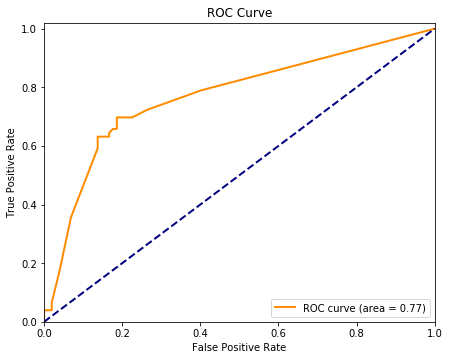

In [171]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, [n[1] for n in y_pred_proba])
roc_auc = auc(fpr, tpr) 

## 绘制roc曲线图
plt.subplots(figsize=(7,5.5));
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.02]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve');
plt.legend(loc="lower right");
plt.show()

In [157]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
#y_pred =  y_pred[:,1]
y_pred = y_pred.tolist()
accuracy = len([n for n in range(len(y_pred)) if y_pred[n]==y_test.iloc[n]])/len(y_pred)
print(accuracy)

0.797752808988764
